In [1]:
import numpy as np
import pandas as pd
import music21

np.random.seed(401)

In [2]:
data = pd.read_csv('data_mapped.csv')
data.head()

,piece,notes
0,./abc/1b651a94a8f8680da3cef1e60705194d.abc,"[[1, 3, 5, 6, 7, 8, 9, 11], [1, 3, 5, 6, 7, 8,..."
1,./abc/3679c385a618c89f00d159f418022b39.abc,"[[1, 3, 4, 5, 7, 8, 9, 11], [1, 4, 5, 6, 7, 8,..."
2,./abc/60ae81952628613e03d563b0dae8bbc2.abc,"[[1, 4, 5, 7, 9, 10, 11, 12], [1, 3, 5, 9, 11]]"
3,./abc/6a7d307d1f0712090e4043a6b4637efa.abc,"[[1, 5, 9], [1, 1, 3, 4, 5, 7, 9, 11], [1, 4, ..."
4,./abc/8c6965e3c831e8cb769e578423c12d1e.abc,"[[1, 5, 7, 8, 9], [1, 3, 4, 5, 6, 7, 8, 9, 10,..."


In [3]:
import ast
# change the note column to list
data['notes'] = data['notes'].apply(ast.literal_eval)

In [4]:
from collections import defaultdict
from collections import Counter

# get the bigram of the music data
bigram = []
bigram_freq = defaultdict(int)

# get the bigram of each song
for i in range(len(data)):
    for bar in data.loc[i,'notes']:
        bigram.extend(zip(bar, bar[1:]))
    
# print(bigram)

# get the frequency of every bigram
bigram_freq = dict(Counter(bigram))
print(len(bigram_freq))


49


In [5]:
# remove the identical bigram
for key in bigram_freq:
    if key[0] == key[1]:
        key = (0,0)
print(len(bigram_freq))

49


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

bigram_counts = np.zeros((12, 12))

# Fill the bigram_counts matrix with the counts from bigram_freq
for (w1, w2), count in bigram_freq.items():
    try:
        bigram_counts[w1 - 1, w2 - 1] = count
    except:
        print('exception:', w1,'->', w2)

# Normalize each row to create the transition probability matrix
row_sums = bigram_counts.sum(axis=1, keepdims=True)
bigram_prob = bigram_counts / row_sums

# Create a DataFrame for better visualization
note_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


exception: 5 -> 13


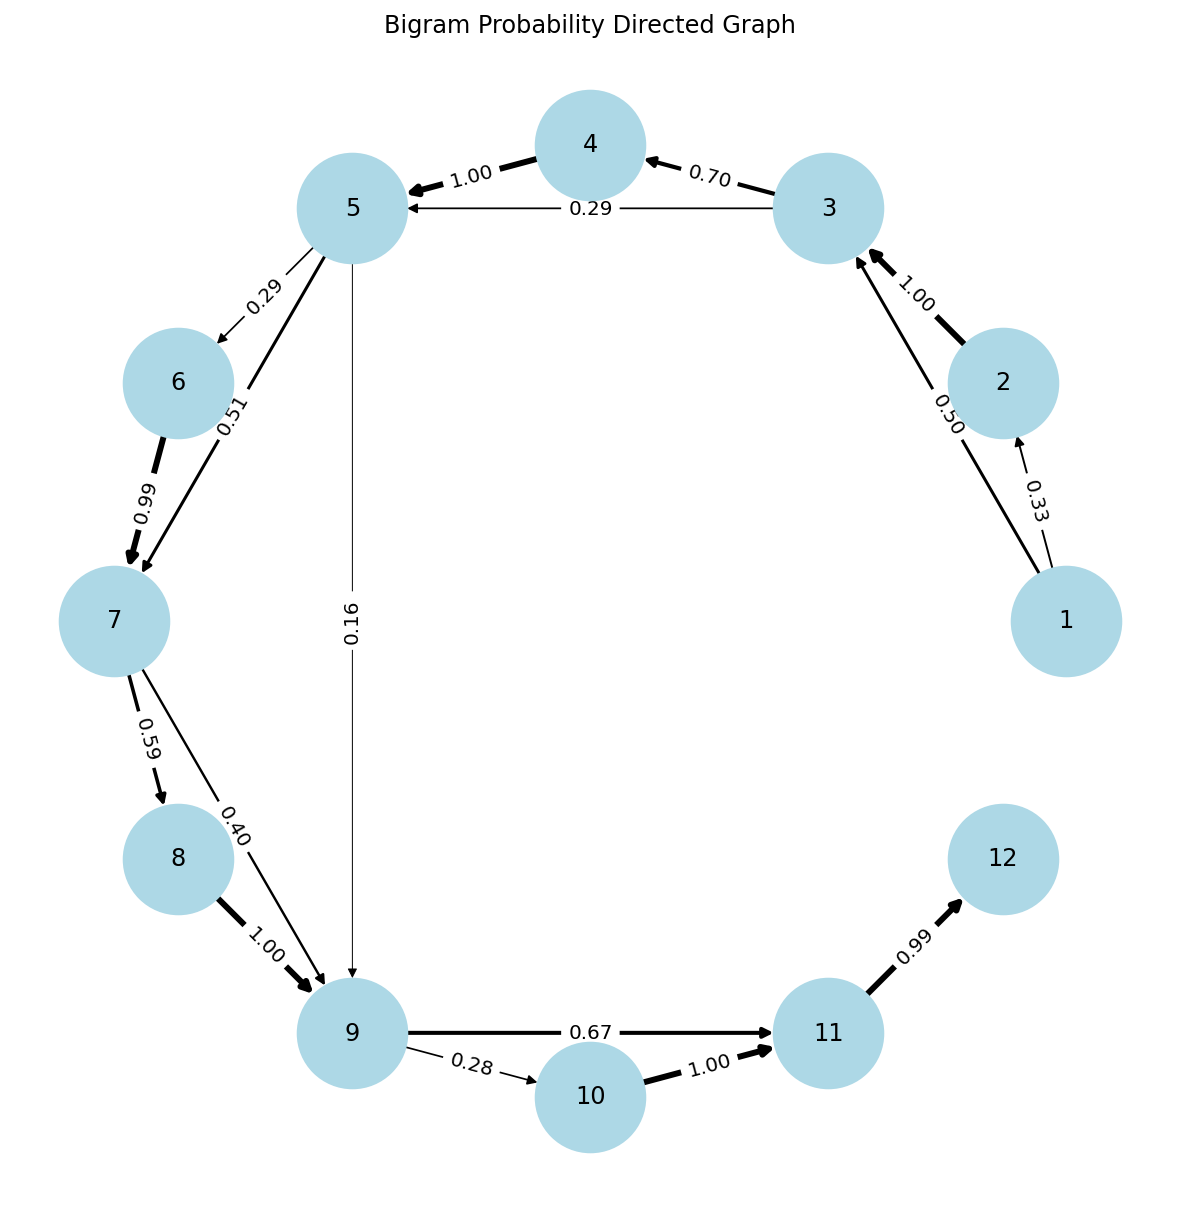

In [7]:
import networkx as nx

# Create a directed graph from the bigram probabilities
G = nx.DiGraph()
for i, row in enumerate(bigram_prob):
    for j, prob in enumerate(row):
        if prob > 0.1:
            G.add_edge(note_labels[i], note_labels[j], weight=prob)

# Visualize the directed graph
plt.figure(figsize=(8,8))

# Create a circular layout with the correct order
pos = {note_labels[i]: (np.cos(2 * np.pi * i / 12), np.sin(2 * np.pi * i / 12)) for i in range(12)}

# Calculate edge widths based on their weights
edge_weights = nx.get_edge_attributes(G, 'weight')
edge_widths = [d * 3 for d in edge_weights.values()]

# Draw the graph with the calculated edge widths and custom positions
nx.draw(G, pos, node_color='lightblue', with_labels=True, node_size=3000, width=edge_widths)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d:.2f}" for (u, v), d in labels.items()})
plt.title('Bigram Probability Directed Graph')
plt.savefig('bigram_probability_directed_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def predict_next_state(bigram_freq, current_state):
    """
    predict the next state based on the bigram frequency
    """
    # get the possible next states
    possible_next_states = [k[1] for k, v in bigram_freq.items() if k[0] == current_state]
    # get the frequency of each possible next state
    freq = [v for k, v in bigram_freq.items() if k[0] == current_state]
    # normalize the frequency
    freq = np.array(freq) / np.sum(freq)
    # predict the next state
    next_state = np.random.choice(possible_next_states, p=freq)
    return next_state

In [9]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

def seq_to_vec(seq):
    return [1 if i+1 in seq else 0 for i in range(12)]

def generate_a_bar(bigram_freq, start_state):
    """
    generate a bar based on the bigram frequency
    """
    bar = [start_state]
    while True:
        next_state = predict_next_state(bigram_freq, bar[-1])
        bar.append(next_state)

        if next_state == 12 or (len(bar) >= 4 and next_state >= 9 and np.random.random() > 0.6):
            break
    return bar

def generate_sequence(bigram_freq, start_state, num_bars, similarity_threshold=0.5):
    """
    generate a sequence based on the bigram frequency
    """
    sequence = [generate_a_bar(bigram_freq, start_state)]
    while len(sequence) < num_bars:
        bar = generate_a_bar(bigram_freq, start_state)
        # compare the similarity between the last bar in the sequence and the new bar
        vec1 = seq_to_vec(sequence[-1])
        vec2 = seq_to_vec(bar)
        similarity = cosine_similarity(vec1, vec2)

        if similarity >= similarity_threshold:
            sequence.append(bar)

    return sequence

In [10]:
# Function that maps a series of numbers between 1 and 12 (position of each sixteenth-note in the bar) to a music21 beat distribution
def map_beats_reverse(notes):
    notes_mapped = []
    for bar in notes:
        bar_mapped = []
        for y in bar:
            bar_mapped.append((y+3)/4)
        notes_mapped.append(bar_mapped)
    return notes_mapped

In [11]:
def convert_to_duration(random_song_list):
    last = 4.0
    # read the list backwards
    random_song_list.reverse()
    # create a list with the duration of each note
    duration_list = []
    for bar in random_song_list:
        # reverse the inner list
        bar.reverse()
        for note in bar:
            duration_list.append(last - note)
            last = note
        last += 4.0
    # reverse the list again
    duration_list.reverse()
    return duration_list

In [12]:
def convert_to_stream(duration_list):
    # create an empty stream
    stream = music21.stream.Stream()
    # define the tempo as 3/4
    stream.append(music21.meter.TimeSignature('3/4'))
    # create note
    # assign random pitch (C4)
    # assign duration (quarter)
    # append the note into empty stream
    for duration in duration_list:
        note = music21.note.Note(pitch='C4', quarterLength=duration)
        stream.append(note)
    return stream

In [13]:
# generate a sequence based on the bigram frequency
sequence = generate_sequence(bigram_freq, start_state=1,num_bars=8,similarity_threshold=0.85)
print(sequence)

[[1, 2, 3, 4, 5, 7, 8, 9], [1, 2, 3, 5, 7, 8, 9], [1, 2, 3, 5, 7, 8, 9, 11, 12], [1, 2, 3, 5, 7, 8, 9], [1, 2, 3, 4, 5, 7, 9], [1, 3, 4, 5, 7, 8, 9], [1, 3, 4, 5, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9]]


In [14]:
new_sequence = map_beats_reverse(sequence)
print(new_sequence)

[[1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0], [1.0, 1.25, 1.5, 2.0, 2.5, 2.75, 3.0], [1.0, 1.25, 1.5, 2.0, 2.5, 2.75, 3.0, 3.5, 3.75], [1.0, 1.25, 1.5, 2.0, 2.5, 2.75, 3.0], [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0], [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]]


In [15]:
stream_example = convert_to_stream(convert_to_duration(new_sequence))
# hear the midi file
stream_example.show('midi')

In [17]:
# generate 500 sequences based on the bigram frequency
# create an empty DataFrame with columns ['id','notes']
sequences = pd.DataFrame(columns=['notes'])
while len(sequences) < 500:
    try:
        sequence = generate_sequence(bigram_freq, start_state=1,num_bars=8,similarity_threshold=0.85)
        sequences = sequences.append({'notes':sequence},ignore_index=True)
    except:
        pass
# save
sequences.to_csv('markov_songs.csv',index=True)